In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import random
import time

import scipy.stats as stats
import seaborn as sns

from zipfile import ZipFile

import os

%matplotlib inline

import adai_optim

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/home/jukie/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_data(X, xlim=[0, 20]):
    plt.figure(figsize=(15, 12) )
    
    for ind_data, data in enumerate(X):
        if ind_data == len(X) - 1:
            for ind, col in enumerate(data.columns.tolist()):
                plt.plot(t, 5 * ind + stats.zscore(data[col], nan_policy='omit'), linewidth=0.5, label=col)
            plt.legend(ncol=6)
        else:
            for ind, col in enumerate(data.columns.tolist()):
                plt.plot(t, 5 * ind + stats.zscore(data[col], nan_policy='omit'), linewidth=0.3, alpha=0.6, color='k', label=None)
    plt.xlim(xlim)

In [3]:
df = pd.read_csv('/home/jukie/Project/eeg-eye-state-classification-master/eeg_eye_state.csv', skiprows = [i for i in range(19)], header=None)
Fs = 128 # (number of samples / 117s length of data mentioned on the data description) rounded to the closest integer.
t = np.arange(0, len(df) * 1 / Fs, 1/Fs)
cols = df.columns.tolist()[:-1]

print( 'Number of null samples:\n' + str(df.isnull().sum()) )
df.head()

Number of null samples:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4312.31,4000.00,4255.90,4124.10,4342.05,4586.67,4085.64,4610.77,4192.31,4223.08,4192.31,4264.62,4614.87,4382.05,0
1,4315.90,4003.59,4257.44,4122.56,4341.54,4588.21,4088.21,4607.18,4188.21,4216.92,4200.00,4270.26,4621.54,4378.97,0
2,4314.36,4005.64,4259.49,4123.59,4345.13,4588.21,4092.31,4612.82,4206.67,4222.56,4209.74,4272.31,4624.62,4381.54,0
3,4324.62,4012.82,4263.08,4132.31,4343.08,4587.18,4091.79,4617.95,4213.33,4240.51,4217.95,4274.36,4632.31,4400.51,0
4,4331.28,4024.10,4266.15,4140.00,4336.41,4585.64,4089.74,4617.95,4204.62,4245.13,4216.41,4274.36,4638.97,4401.54,0


In [4]:
# separate targets so you can preprocess the EEG data easily
Y = df.loc[:,14:]
print( Y.shape )

X = df.loc[:,0:13]
print( X.shape )

(14962, 1)
(14962, 14)


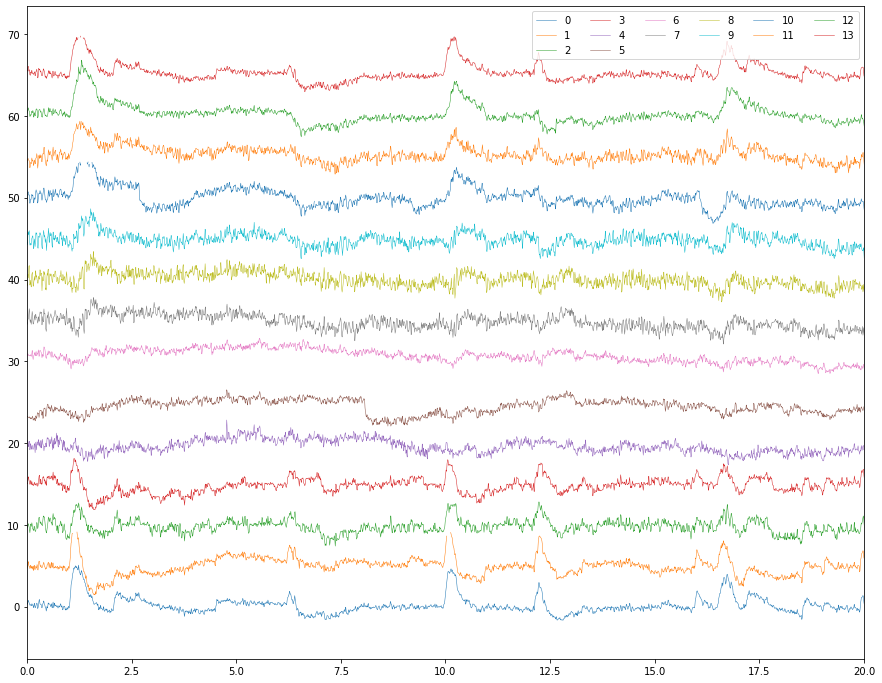

In [5]:
# Find outliers and put Nan instead
X = X.apply(stats.zscore, axis=0)
X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )

# recalculate outliers with ignoring nans since the first calculation was biased with the huge outliers!
X = X.apply(stats.zscore, nan_policy='omit', axis=0)
X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )

plot_data([X])

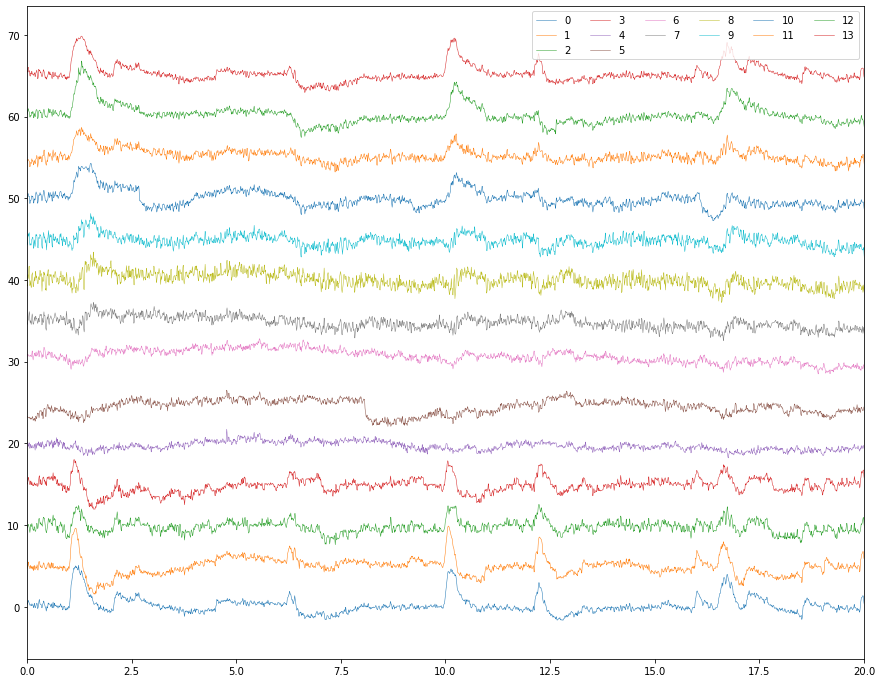

In [6]:
from scipy import signal, interpolate

def interp(x):
    t_temp = t[ x.index[ ~x.isnull() ] ]
    x = x[ x.index[ ~x.isnull() ] ]
    clf = interpolate.interp1d(t_temp, x, kind='cubic')
    return clf(t)

# interpolate the nans using cubic spline method
X_interp = X.apply(interp, axis=0)

plot_data([X_interp])

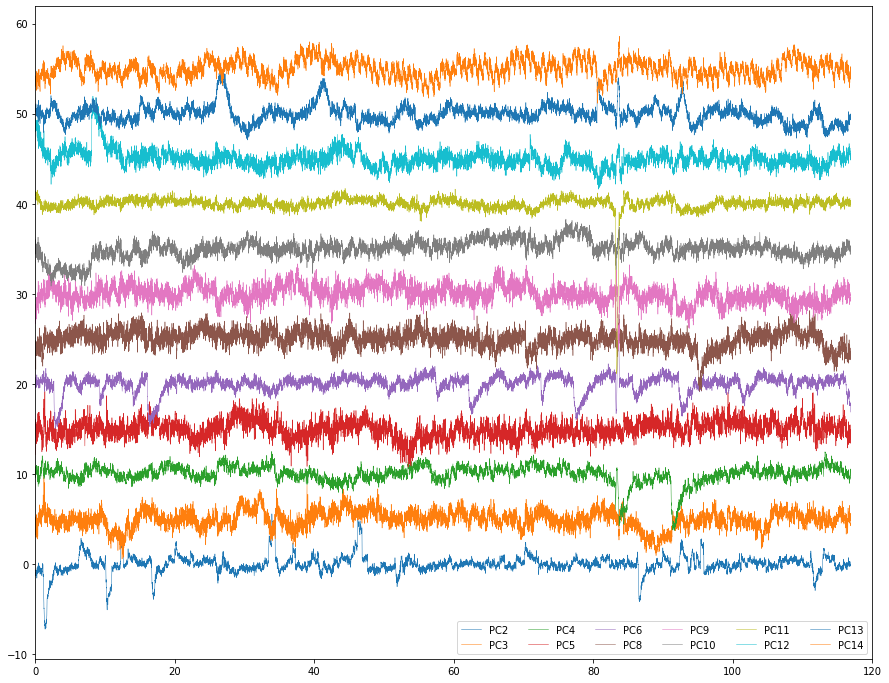

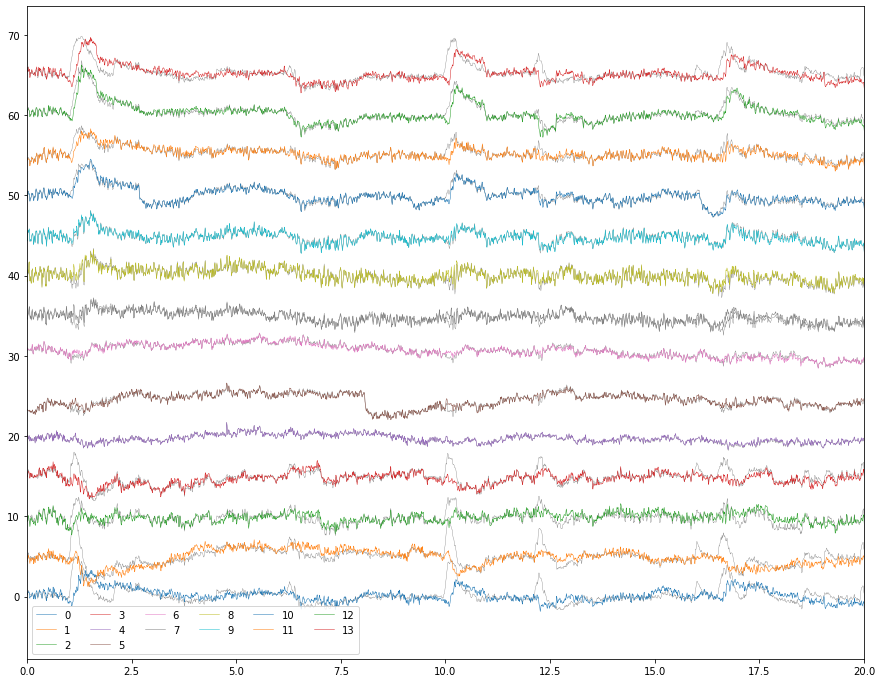

In [7]:
# ICA
from sklearn.decomposition import FastICA

# apply ICA to drop non-electrophysiolgoical components (requires familiarity with EEG data)
ica = FastICA(max_iter=2000, random_state=0)
X_pcs = pd.DataFrame( ica.fit_transform(X_interp) )
X_pcs.columns = ['PC' + str(ind+1) for ind in range(X_pcs.shape[-1])]
X_pcs = X_pcs.drop(columns=['PC1', 'PC7'])
plot_data([X_pcs], xlim=[0, 120])

# reconstruct clean EEG after dropping the bad components
ica.mixing_ = np.delete(ica.mixing_, [0, 6], axis = 1)
X_interp_clean = pd.DataFrame( ica.inverse_transform(X_pcs) )
X_interp_clean.columns = cols

plot_data([X_interp, X_interp_clean], xlim=[0, 20])

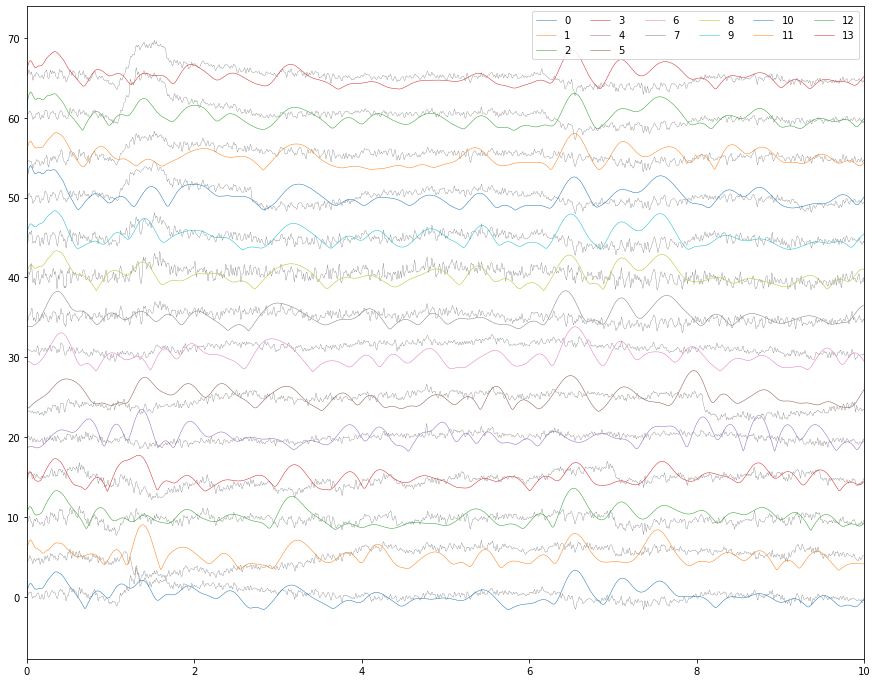

In [8]:
# now that data is clean, extract alpha waves magnitude from the clean signals

# filter the data between 8-12 Hz (note that data has been rescaled to original scale after filtering for comparable visualization)
b, a = signal.butter(6, [8 / Fs * 2, 12 / Fs * 2], btype='bandpass')
X_interp_clean_alpha = X_interp_clean.apply(lambda x: signal.filtfilt(b, a, x) / max(abs(signal.filtfilt(b, a, x))) * max(abs(x)), axis=0)

# extract envelope of the Alpha waves
X_interp_clean_alpha = X_interp_clean_alpha.apply(lambda x: np.abs(signal.hilbert(x)), axis=0)
X_interp_clean_alpha.columns = cols
X = X_interp_clean_alpha
plot_data([X_interp_clean, X_interp_clean_alpha], xlim=[0, 10])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, stratify=Y, shuffle=True)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [11]:
print(f"Training Data has {len(X_train)} examples")
print(f"Testing Data has {len(X_test)} examples")

Training Data has 12717 examples
Testing Data has 2245 examples


In [12]:
y_train = y_train.to_numpy()


In [13]:
y_test =y_test.to_numpy()

In [14]:
## Train Data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## Test Data    
class testData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test),
                    torch.FloatTensor(y_test))

In [15]:
train_data

In [16]:
class accData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

acc_data = accData(torch.FloatTensor(X_test))

In [17]:
# Create DataLoaders for torch
BATCH_SIZE = 100
LEARNING_RATE=0.001
EPOCHS=50

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE,)
acc_loader = DataLoader(dataset=acc_data, batch_size=1)

In [18]:
class eca_layer(nn.Module):
    """Constructs a ECA module.

    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)

In [19]:
class MLPNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.dim = nn.Linear(1, 128)
        self.layer_1 = nn.Linear(128, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.eca1 = eca_layer(3)
        self.eca2 = eca_layer(3)
        self.flat = nn.Sequential(
            nn.Linear(1792,128),
            #nn.Dropout(p=0.5),
            nn.ReLU())
        self.layer_out = nn.Linear(128, 1)
        
        self.leakyRelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(14)
        self.batchnorm2 = nn.BatchNorm1d(14)

        self.attblock = nn.Sequential(
            eca_layer(3),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(14),
            nn.Dropout(p=0.25),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(14),
            #nn.Dropout(p=0.25)
        )

    def forward(self, x):
        x = torch.unsqueeze(x,2)
        x = self.dim(x)
        '''
        #x = self.eca1(x)
        x = self.leakyRelu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.leakyRelu(self.layer_2(x))
        x = self.batchnorm2(x)
        '''
        x = self.attblock(x)
        x = self.attblock(x)
        
        #x = self.eca2(x)
        x = self.dropout(x)
        x = torch.flatten(x,1)
        x = self.flat(x)
        x = self.layer_out(x)
        return x

model = MLPNetwork()

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 328,954 trainable parameters


In [21]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=5e-4)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = adai_optim.Adai(model.parameters(), lr=LEARNING_RATE, betas=(0.1, 0.99), eps=1e-03, weight_decay=5e-4)
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda:0')

In [22]:
model = model.to(device)
criterion = criterion.to(device)

In [23]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [24]:
#model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0
    model.train()
    for X_batch, y_batch in train_loader:
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        acc = accuracy(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    model.eval()
    for X_batch, y_batch in test_loader:
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        
        y_pred = model(X_batch)
        tloss = criterion(y_pred, y_batch)
        tacc = accuracy(y_pred, y_batch)
                
        tepoch_loss += tloss.item()
        tepoch_acc += tacc.item()
        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')    
    print(f'Epoch {e+0:03}: | tLoss: {tepoch_loss/len(test_loader):.5f} | tAcc: {tepoch_acc/len(test_loader):.3f}')

Epoch 001: | Loss: 0.65698 | Acc: 59.828
Epoch 001: | tLoss: 0.61492 | tAcc: 66.391
Epoch 002: | Loss: 0.55733 | Acc: 70.906
Epoch 002: | tLoss: 0.51960 | tAcc: 75.522
Epoch 003: | Loss: 0.44849 | Acc: 78.750
Epoch 003: | tLoss: 0.44178 | tAcc: 79.304
Epoch 004: | Loss: 0.34338 | Acc: 85.273
Epoch 004: | tLoss: 0.30803 | tAcc: 87.000
Epoch 005: | Loss: 0.26493 | Acc: 89.109
Epoch 005: | tLoss: 0.30717 | tAcc: 86.696
Epoch 006: | Loss: 0.20635 | Acc: 92.102
Epoch 006: | tLoss: 0.24115 | tAcc: 89.870
Epoch 007: | Loss: 0.16799 | Acc: 93.938
Epoch 007: | tLoss: 0.13507 | tAcc: 95.261
Epoch 008: | Loss: 0.12184 | Acc: 95.922
Epoch 008: | tLoss: 0.11496 | tAcc: 96.522
Epoch 009: | Loss: 0.09340 | Acc: 97.164
Epoch 009: | tLoss: 0.14643 | tAcc: 94.217
Epoch 010: | Loss: 0.09017 | Acc: 96.992
Epoch 010: | tLoss: 0.09184 | tAcc: 96.739
Epoch 011: | Loss: 0.08144 | Acc: 97.438
Epoch 011: | tLoss: 0.10947 | tAcc: 95.870
Epoch 012: | Loss: 0.07598 | Acc: 97.492
Epoch 012: | tLoss: 0.08217 | tAcc:

In [25]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in acc_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [26]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1236
           1       0.98      0.98      0.98      1009

    accuracy                           0.98      2245
   macro avg       0.98      0.98      0.98      2245
weighted avg       0.98      0.98      0.98      2245



In [27]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1236
           1       0.98      0.98      0.98      1009

    accuracy                           0.98      2245
   macro avg       0.98      0.98      0.98      2245
weighted avg       0.98      0.98      0.98      2245



In [28]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1236
           1       0.98      0.98      0.98      1009

    accuracy                           0.98      2245
   macro avg       0.98      0.98      0.98      2245
weighted avg       0.98      0.98      0.98      2245

